We have a dataset, which according to the U.S. Energy Information Administration, captures the monthly net electricity generation from coal in the country. The numbers are in Kilowatthours.

The goal of this exercise is to build a SARIMA model to forecast values till 2030.

In [ ]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 5.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error
%matplotlib inline
import itertools
import warnings
plt.style.use('ggplot')

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/shrutibalan4591/Practise/main/Time%20Series/SARIMA/Electricity_Net_Generation_From_Coal_Electric_Power_Sector_Monthly.csv')
data.head()

,Date,Electricity
0,Jan-73,75190.149
1,Feb-73,67797.946
2,Mar-73,67387.612
3,Apr-73,63935.049
4,May-73,64927.181


<Figure size 864x360 with 0 Axes>

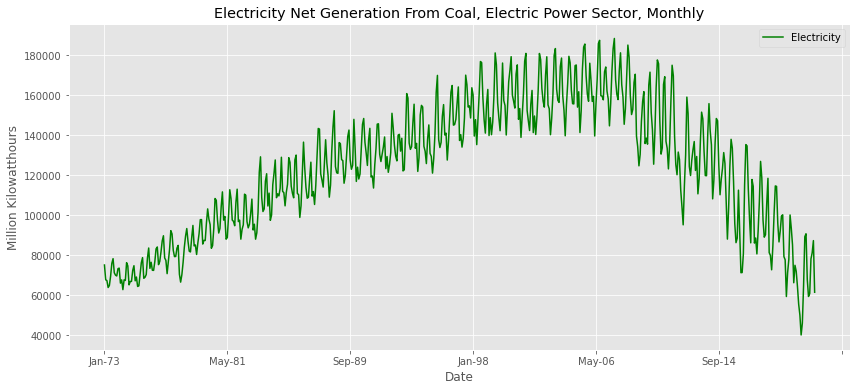

In [ ]:
#Visualize net electricity generation from coal since 1973
plt.figure(figsize=[12, 5])
data.plot(x='Date', y='Electricity', figsize = (14, 6), legend = True, color='g')
plt.title('Electricity Net Generation From Coal, Electric Power Sector, Monthly')
plt.ylabel('Million Kilowatthours')
plt.xlabel('Date')
#plt.xticks(rotation=90)
plt.grid(True)
plt.show()

**Testing the Stationarity of the Dataset**

In [ ]:
# Augmented Dickey-Fuller test (ADF Test)
ad_fuller_result = adfuller(data['Electricity'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.1428788781480845
p-value: 0.6976730759149157


*Conclusion*: Data is non stationery.



---
**Differencing**


In [ ]:
# First order
data['Electricity First Difference'] = data['Electricity'] - data['Electricity'].shift(1)
data.dropna(subset = ["Electricity First Difference"], inplace=True)
data.head()

,Date,Electricity,Electricity First Difference
1,Feb-73,67797.946,-7392.203
2,Mar-73,67387.612,-410.334
3,Apr-73,63935.049,-3452.563
4,May-73,64927.181,992.132
5,Jun-73,69592.039,4664.858


In [ ]:
ad_fuller_result = adfuller(data['Electricity First Difference'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.082264335282704
p-value: 1.0850793453620318e-07


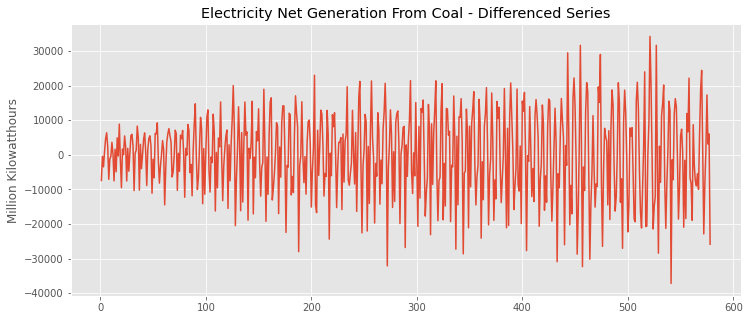

In [ ]:
plt.figure(figsize=[12, 5]); # Set dimensions for figure
data['Electricity First Difference'].plot()
plt.title('Electricity Net Generation From Coal - Differenced Series')
plt.ylabel('Million Kilowatthours')
plt.grid(True)

**ACF and PACF Plots**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


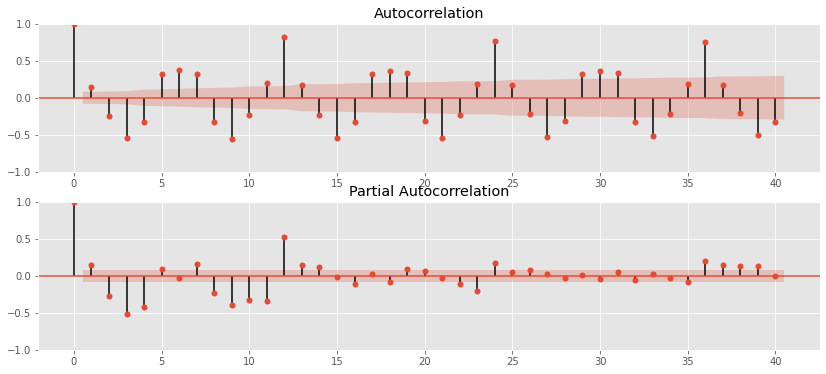

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Electricity First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Electricity First Difference'].dropna(),lags=40,ax=ax2)

In [ ]:
best_model = SARIMAX(data['Electricity'], order=(2, 1, 2), seasonal_order=(2, 1, 2, 12)).fit(dis=-1)
print(best_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  FutureWarning


                                     SARIMAX Results                                      
Dep. Variable:                        Electricity   No. Observations:                  578
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -5697.590
Date:                            Sun, 30 Jan 2022   AIC                          11413.179
Time:                                    06:50:01   BIC                          11452.211
Sample:                                         0   HQIC                         11428.414
                                            - 578                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4891      1.990      0.246      0.806      -3.411       4.389
ar.L2         -0.1146      0.735   

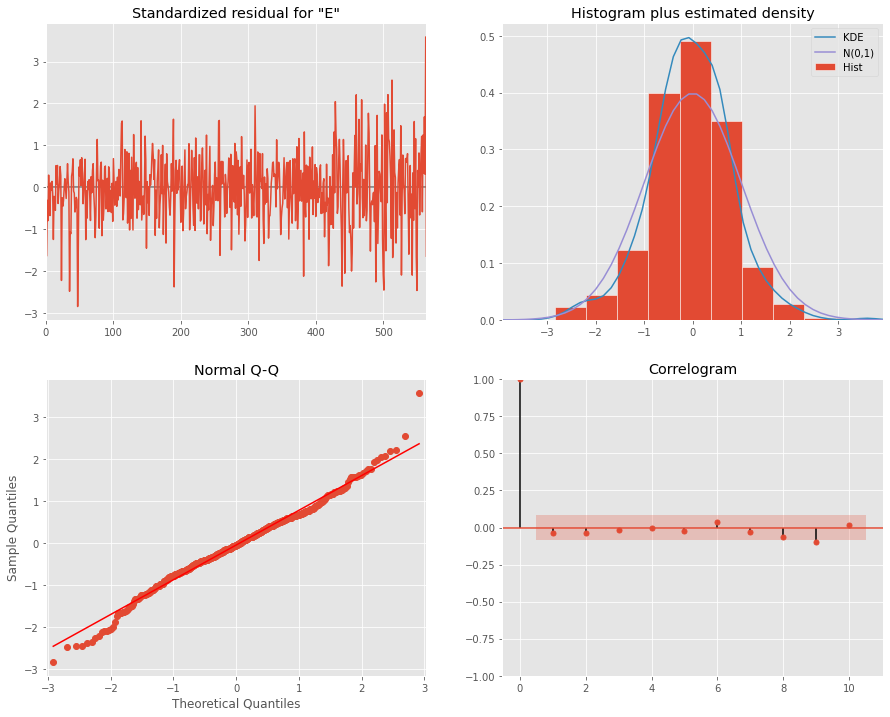

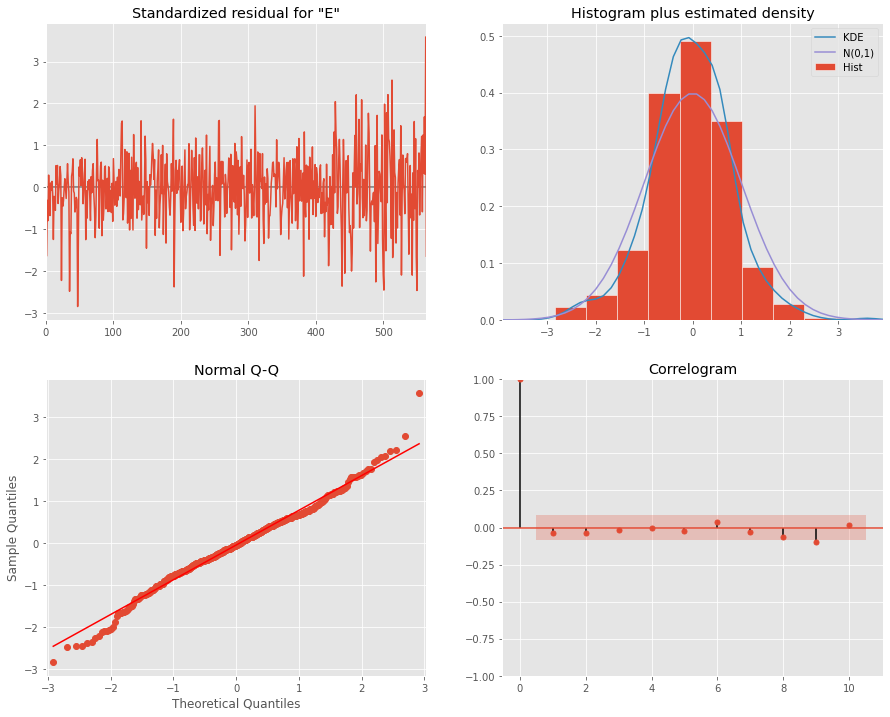

In [ ]:
#Diagnosing the model residuals
best_model.plot_diagnostics(figsize=(15,12))

The correlogram on the bottom right suggests that there is no autocorrelation in the residuals, and so they are effectively white noise. Therefore, these residuals are uncorrelated and the mean is close to zero.

**Model Forecast**

In the forecast step, we will try to predict the electricity generation data for the next 160 steps or 10 years.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


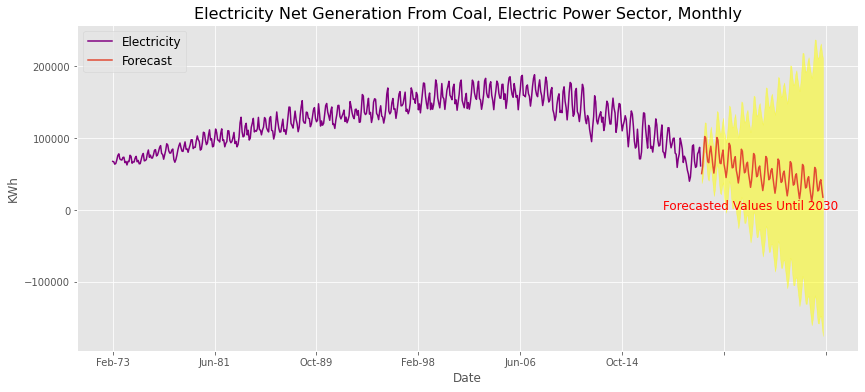

In [ ]:
#Forecasting 10 years ahead
forecast_values = best_model.get_forecast(steps = 120)

#Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

#Plot the data
ax = data.plot(x='Date', y='Electricity', figsize = (14, 6), legend = True, color='purple')

#Plot the forecasted values 
forecast_values.predicted_mean.plot(ax=ax, label='Forecast', figsize = (14, 6), grid=True)

#Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='yellow', alpha = .5)
plt.title('Electricity Net Generation From Coal, Electric Power Sector, Monthly', size = 16)
plt.ylabel('KWh', size=12)
plt.legend(loc='upper left', prop={'size': 12})
ax.axes.get_xaxis().set_visible(True)
#annotation
ax.text(540, 400, 'Forecasted Values Until 2030', fontsize=12,  color='red')
plt.show()

In [ ]:
#divide into train and validation set to calculate R-squared score and mean absolute percentage error 
train = data[:int(0.85*(len(data)))]
test = data[int(0.85*(len(data))):]
start=len(train)
end=len(train)+len(test)-1
predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Electricity'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['Electricity'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['Electricity'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['Electricity'], predictions))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['Electricity'])
                                                               /np.abs(test['Electricity']))*100 
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,0.900273,6405.520815,6.490222e+07,8056.191123,7.087797
